In [1]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            # Resize and normalize
            img_resized = cv2.resize(img, (16, 16)) / 255.0
            # Flatten
            img_flattened = img_resized.flatten()
            images.append(img_flattened)
    return np.array(images)

# Load images for class 0 and 5
class_0_images = load_images_from_folder("../data/svm/train/0")
class_5_images = load_images_from_folder("../data/svm/train/5")

class_0_images.shape, class_5_images.shape


((2380, 768), (2380, 768))

# CVXOPT Linear Kernel SVM

In [2]:
from cvxopt import matrix

# Define labels for the two classes: class 0 as -1 and class 5 as +1
y_0 = -1 * np.ones(class_0_images.shape[0])
y_5 = np.ones(class_5_images.shape[0])

# Combine data and labels
X = np.vstack((class_0_images, class_5_images))
y = np.hstack((y_0, y_5))

P = np.outer(y, y) * np.dot(X, X.T)

q = -1 * np.ones(X.shape[0])
A = y
b = 0.0
G = np.vstack((-np.eye(X.shape[0]), np.eye(X.shape[0])))
h = np.hstack((np.zeros(X.shape[0]), np.ones(X.shape[0]) * 1.0))  # C = 1.0

P = matrix(P)
q = matrix(q)
A = matrix(A, (1, X.shape[0]))
b = matrix(b)
G = matrix(G)
h = matrix(h)

P, q, A, b, G, h

(<4760x4760 matrix, tc='d'>,
 <4760x1 matrix, tc='d'>,
 <1x4760 matrix, tc='d'>,
 <1x1 matrix, tc='d'>,
 <9520x4760 matrix, tc='d'>,
 <9520x1 matrix, tc='d'>)

In [3]:
from cvxopt import solvers

# Solve the QP problem
solvers.options['show_progress'] = True
solution = solvers.qp(P, q, G, h, A, b)

# Extract alphas
alphas = np.array(solution['x'])

# Calculate w using the alphas
w = np.sum(alphas * y[:, None] * X, axis=0)

# Calculate b
SV = (alphas > 1e-5).flatten()
b = y[SV] - np.dot(X[SV], w)
b = np.mean(b)

# For predictions: np.sign(np.dot(X, w) + b)

print("Weight vector (w):", w)
print("Intercept (b):", b)

     pcost       dcost       gap    pres   dres
 0: -2.5963e+03 -1.3703e+04  7e+04  3e+00  1e-10
 1: -1.7917e+03 -1.0056e+04  2e+04  5e-01  8e-11
 2: -1.5840e+03 -5.2708e+03  5e+03  8e-02  6e-11
 3: -1.7450e+03 -2.7358e+03  1e+03  2e-02  6e-11
 4: -1.8993e+03 -2.3548e+03  5e+02  6e-03  6e-11
 5: -1.9660e+03 -2.2023e+03  2e+02  3e-03  6e-11
 6: -2.0104e+03 -2.1059e+03  1e+02  8e-04  7e-11
 7: -2.0286e+03 -2.0666e+03  4e+01  8e-05  7e-11
 8: -2.0403e+03 -2.0484e+03  8e+00  5e-06  8e-11
 9: -2.0429e+03 -2.0448e+03  2e+00  9e-07  7e-11
10: -2.0436e+03 -2.0439e+03  3e-01  1e-07  7e-11
11: -2.0437e+03 -2.0438e+03  2e-02  7e-09  8e-11
12: -2.0437e+03 -2.0437e+03  7e-04  2e-10  8e-11
Optimal solution found.
Weight vector (w): [-0.917249   -0.44200238  0.84523203 -0.84925474 -0.47666238  1.01249138
  0.20687805 -0.79081624  0.58541163  0.01083122  0.29591497 -0.20428939
 -0.23601894 -0.13552678  0.00948478  0.2784127   0.25000897 -0.59609479
  0.51654891 -0.00238444 -0.72837606  0.38641764  1.1

In [4]:
# Extract boolean array indicating which samples are support vectors
support_vector_indices = alphas > 1e-5

# Count the number of support vectors
num_support_vectors = np.sum(support_vector_indices)

# Calculate the percentage of training samples that are support vectors
percentage_support_vectors = (num_support_vectors / X.shape[0]) * 100

num_support_vectors, percentage_support_vectors

(2383, 50.063025210084035)

In [5]:
np.sign(np.dot(X, w) + b)

array([ 1., -1., -1., ..., -1.,  1.,  1.])

In [6]:
# Validation

# load images for class 0 and 5
class_0_images_val = load_images_from_folder("../data/svm/val/0")
class_5_images_val = load_images_from_folder("../data/svm/val/5")

# Define labels for the two classes: class 0 as -1 and class 5 as +1
y_0_val = -1 * np.ones(class_0_images_val.shape[0])
y_5_val = np.ones(class_5_images_val.shape[0])

# Combine data and labels
X_val = np.vstack((class_0_images_val, class_5_images_val))
y_val = np.hstack((y_0_val, y_5_val))

# Predict
y_pred = np.sign(np.dot(X_val, w) + b)

# Calculate accuracy
accuracy = np.sum(y_pred == y_val) / y_val.shape[0]

print("Accuracy:", accuracy)

Accuracy: 0.775


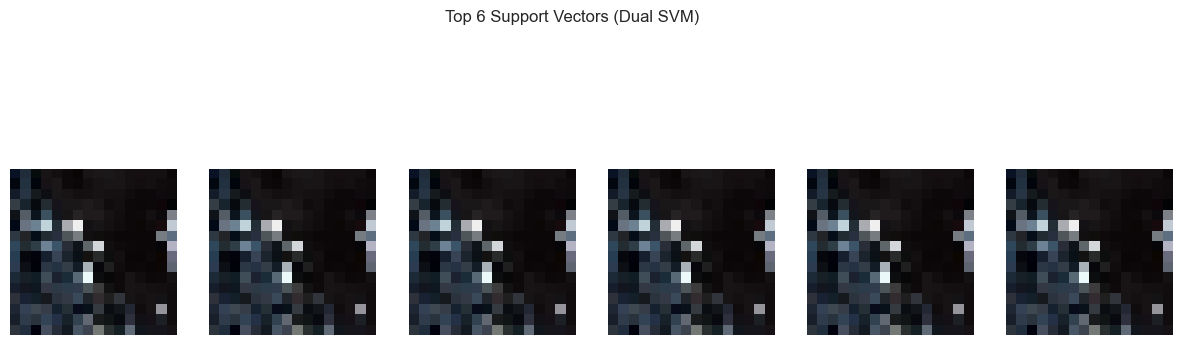

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


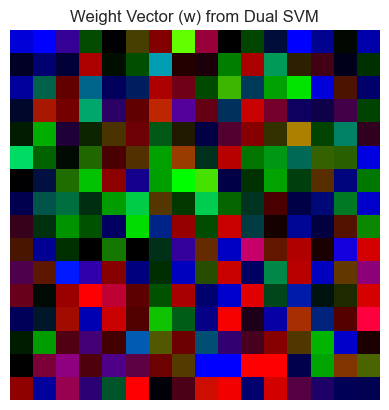

In [7]:
import matplotlib.pyplot as plt

# Get support vectors and their coefficients from the dual solution
support_vectors_dual = X[SV]
dual_coefs = alphas[SV]

# Get indices of top 6 coefficients
top_indices_dual = np.argsort(dual_coefs)[-6:]

# Reshape and plot the support vectors corresponding to top 6 coefficients
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(support_vectors_dual[top_indices_dual[i]].reshape(16, 16, 3))
    ax.axis('off')

plt.suptitle("Top 6 Support Vectors (Dual SVM)")
plt.savefig("top_6_support_vectors_dual cvxopt linear.png")
plt.show()

# Reshape and plot the weight vector w
plt.imshow(w.reshape(16, 16, 3))
plt.title("Weight Vector (w) from Dual SVM")
plt.axis('off')
plt.savefig("weight_vector_dual cvxopt linear.png")
plt.show()


# LIBSVM Linear Kernel SVM

In [8]:
X_train = np.vstack((class_0_images, class_5_images))   
y_train = np.hstack((y_0, y_5))

In [9]:
from sklearn.svm import SVC

linear_svm = SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train, y_train)

linear_support_vectors = linear_svm.support_vectors_
linear_nSV = len(linear_support_vectors)
linear_w = linear_svm.coef_
linear_b = linear_svm.intercept_

print("Number of support vectors:", linear_nSV)
print("Percentage of support vectors:", linear_nSV / len(X_train) * 100)
print("Weight vector (w):", linear_w)
print("Intercept (b):", linear_b)

Number of support vectors: 2371
Percentage of support vectors: 49.8109243697479
Weight vector (w): [[-9.18000905e-01 -4.41319679e-01  8.44851191e-01 -8.49707564e-01
  -4.74939273e-01  1.01142588e+00  2.07492980e-01 -7.91829244e-01
   5.85269425e-01  1.12411849e-02  2.95373677e-01 -2.03671241e-01
  -2.35664365e-01 -1.35174483e-01  8.76338762e-03  2.78602475e-01
   2.49656797e-01 -5.96097393e-01  5.16548060e-01 -3.26908393e-03
  -7.27926148e-01  3.85478571e-01  1.16358758e+00 -7.21448952e-01
   5.99205691e-01 -1.96466116e-01  2.28308707e-01  4.71357294e-03
  -4.18797216e-03 -2.05962958e-01 -2.48006857e-01  2.76283060e-01
  -1.00137377e-01 -5.10621744e-01  5.44430757e-02  2.32437935e-01
  -3.25681839e-01 -4.99630145e-01  1.03574753e+00 -5.13054197e-01
   1.32424780e-02  5.67935593e-01 -4.86057132e-02  3.22103326e-02
  -8.91882026e-02 -3.86988073e-01 -5.06840528e-01  6.71957998e-01
  -2.65590246e-02 -1.38615775e-01  1.56647473e-01 -3.39689051e-01
  -3.01057668e-02  4.40794871e-01 -1.389353

In [10]:
linear_val_accuracy = linear_svm.score(X_val, y_val)

linear_val_accuracy

0.78

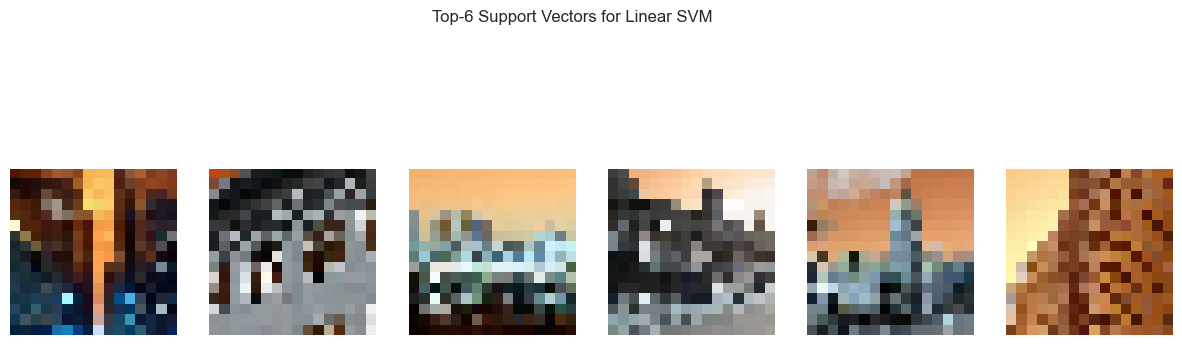

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


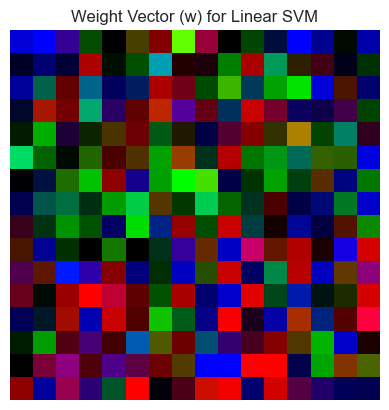

In [11]:
import matplotlib.pyplot as plt

def plot_support_vectors(svm, X_train, title):
    """Plot the support vectors corresponding to the top-6 coefficients."""
    support_indices = np.argsort(np.abs(svm.dual_coef_))[:, -6:]
    support_images = X_train[support_indices].reshape(-1, 16, 16, 3)
    
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for ax, img in zip(axes, support_images):
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)

# Plotting top-6 support vectors for linear SVM
plot_support_vectors(linear_svm, X_train, "Top-6 Support Vectors for Linear SVM")
plt.savefig("top_6_support_vectors_linear libsvm linear.png")
plt.show()

# Reshaping and plotting the weight vector w for the linear SVM
plt.imshow(linear_w.reshape(16, 16, 3))
plt.title("Weight Vector (w) for Linear SVM")
plt.axis('off')
plt.savefig("weight_vector_linear libsvm linear.png")
plt.show()

# LIBSVM Gaussian (RBF) Kernel SVM

In [12]:
# Training an SVM with Gaussian (RBF) kernel using scikit-learn
rbf_svm = SVC(kernel='rbf', C=1.0, gamma=0.001)
rbf_svm.fit(X_train, y_train)

rbf_support_vectors = rbf_svm.support_vectors_
rbf_nSV = len(rbf_support_vectors)

rbf_val_accuracy = rbf_svm.score(X_val, y_val)

print("Number of support vectors:", rbf_nSV)
print("Percentage of support vectors:", rbf_nSV / len(X_train) * 100)
print("Validation accuracy:", rbf_val_accuracy)
print("Weight vector (w):", rbf_svm.dual_coef_)
print("Intercept (b):", rbf_svm.intercept_)

Number of support vectors: 3054
Percentage of support vectors: 64.15966386554622
Validation accuracy: 0.7525
Weight vector (w): [[-1. -1. -1. ...  1.  1.  1.]]
Intercept (b): [-1.06220987]


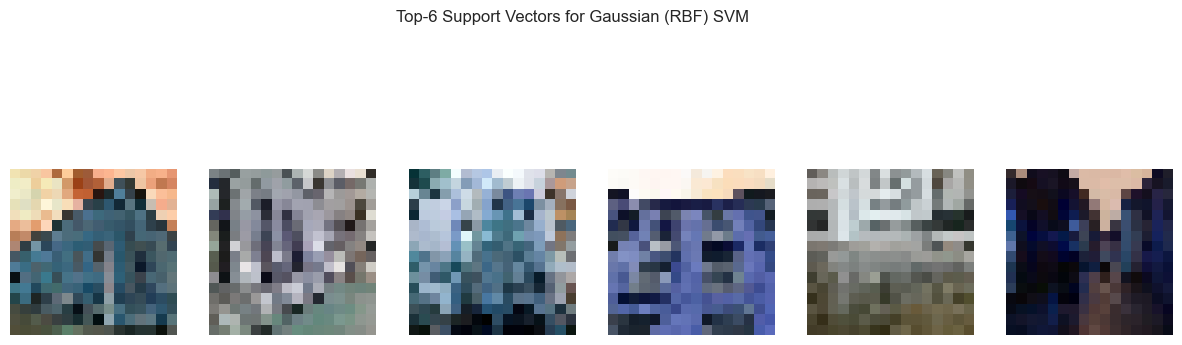

In [13]:
plot_support_vectors(rbf_svm, X_train, "Top-6 Support Vectors for Gaussian (RBF) SVM")
plt.savefig("top_6_support_vectors_rbf libsvm rbf.png")
plt.show()

# CVXOPT Gaussian Kernel SVM

In [14]:
def gaussian_kernel(x1, x2, gamma=0.001):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)


In [15]:
P = np.zeros((X.shape[0], X.shape[0]))
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        P[i, j] = y[i] * y[j] * gaussian_kernel(X[i], X[j])


In [ ]:
from numpy import double

# Define other matrices as before
q = -1 * np.ones(X.shape[0])
G = np.vstack((-np.eye(X.shape[0]), np.eye(X.shape[0])))
h = np.hstack((np.zeros(X.shape[0]), np.ones(X.shape[0]) * 1.0))  # C = 1.0
A = y.astype(double)
b = 0.0

# Convert to cvxopt matrix format and solve
P = matrix(P)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A, (1, X.shape[0]))
b = matrix(b)

solution = solvers.qp(P, q, G, h, A, b)
alphas = np.array(solution['x'])

     pcost       dcost       gap    pres   dres
 0: -3.0573e+03 -1.3944e+04  7e+04  3e+00  6e-13
 1: -2.0948e+03 -1.0001e+04  1e+04  2e-01  6e-13
 2: -2.2663e+03 -3.4451e+03  1e+03  2e-02  5e-13
 3: -2.6058e+03 -3.0009e+03  4e+02  5e-03  5e-13
 4: -2.7139e+03 -2.8783e+03  2e+02  2e-03  6e-13
 5: -2.7605e+03 -2.8255e+03  7e+01  6e-04  6e-13
 6: -2.7804e+03 -2.8029e+03  2e+01  2e-04  6e-13


In [ ]:
support_vector_indices = (alphas > 1e-5).flatten()
support_vectors = X[support_vector_indices]

In [ ]:
def predict(X):
    y_pred = []
    for x in X:
        prediction = sum(alphas[i] * y[i] * gaussian_kernel(support_vectors[i], x) 
                         for i in range(len(support_vectors)))
        y_pred.append(np.sign(prediction))
    return np.array(y_pred)

y_val_pred = predict(X_val)


In [ ]:
y_val, y_val_pred

In [ ]:
y_val_pred = y_val_pred.flatten()

In [ ]:
y_val_pred == y_val

In [ ]:
np.sum(y_val_pred == y_val) / y_val.shape[0]

In [ ]:
val_accuracy = np.sum(y_val_pred == y_val) / X_val.shape[0]

In [ ]:
print("Validation accuracy with Gaussian kernel:", val_accuracy*100)